In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime,timedelta,date,time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from collections import Counter

In [ ]:
column_names = ['DateTime', 'y']
area = 'C:/Users/home/Desktop/Smart-Meter/ratiodata/'
dir_path = os.getcwd()

In [87]:
# 將所有用戶資料讀取進來，儲存在 dt 中
# dt 為 dict，key:用戶名稱，value:該用戶之所有 data 之 DataFrame
dt = {}
for d_name in region[region_name].values.flatten():
    #print(d_name)
    dpath = area + d_name + '.csv'
    dt[d_name] = pd.read_csv(dpath)
    dt[d_name].columns = column_names
    dt[d_name]['DateTime'] = pd.to_datetime(dt[d_name]['DateTime'])  

In [26]:
# 輸入一個 DataFrame，開始與結束的月份，回傳符合條件的所有紀錄
def get_DT_between_month(dataT, start_month, end_month):
    return dataT[[start_month<=dtime.month<=end_month for dtime in dataT['DateTime']]]
#get_DT_between_month(dt['M00001'], 6, 9)

In [27]:
# 輸入一個 DataFrame，回傳非假日的所有紀錄
def get_weekday_DT(dataT):
    return dataT[[0<=dtime.weekday()<=4 for dtime in dataT['DateTime']]]
#get_weekday_DT(dt['M00001.csv'])

In [88]:
# 將所有 6~9 月份的非假日資料過濾出來
summer_dt = {}
for k in dt.keys():
    summer_dt[k] = get_weekday_DT(get_DT_between_month(dt[k], 6, 9))

In [89]:
# all_times 為所有時間點的 datetime.time，[00:00, 01:0, 02:00, ... , 23:00,00:00]
all_times = [time(hour=1, minute=0, second=0)]
while True:
    next_time = datetime.combine(date.today(), all_times[-1]) + timedelta(hours=1)
    #next_time = all_times[-1] + time.timedelta(minutes=15)
    if next_time.time() == all_times[0]:
        break
    all_times.append(next_time.time())
    

In [90]:
# 將每個 user 的所有時間點用電情形做整理
# summer_tdt 為 dict, key: 用戶名稱
#                   , value: 該用戶的每個時間點用電情形, 為 dict
# 用戶用電情形, key: 時間點, ex: 01:00
#           , value: list, 所有該用戶在該時間點用電的紀錄, ex: [ 0.2, 0.3, 0.4]
summer_tdt = {}
for k in summer_dt.keys():
    #print(k)
    summer_tdt[k] = {}
    for t in all_times:
        summer_tdt[k][t] = []
    
    for i in range(len(summer_dt[k])):
        if np.isnan(summer_dt[k]['y'].iloc[i]):
            continue
        summer_tdt[k][summer_dt[k]['DateTime'].iloc[i].time()].append(summer_dt[k]['y'].iloc[i])

In [91]:
# 將所有 user 的所有時間點用電取 mean，並儲存在 summer_avgdt
# summer_avgdt 為 dict, key: 每個時間點
#                     , value: list, 紀錄每個 user 該時段平均用電
summer_avgdt = {}
for t in all_times:
    summer_avgdt[t] = []
    for k in summer_dt.keys():
        summer_avgdt[t].append(np.mean(summer_tdt[k][t]))

In [92]:
# 對每個時間點做boxplot。想看，整體而言，所有用戶在每個時段用電的差異
summer_avgdt_list = []
for i in range(len(all_times)):
    summer_avgdt_list.append(summer_avgdt[all_times[i]])

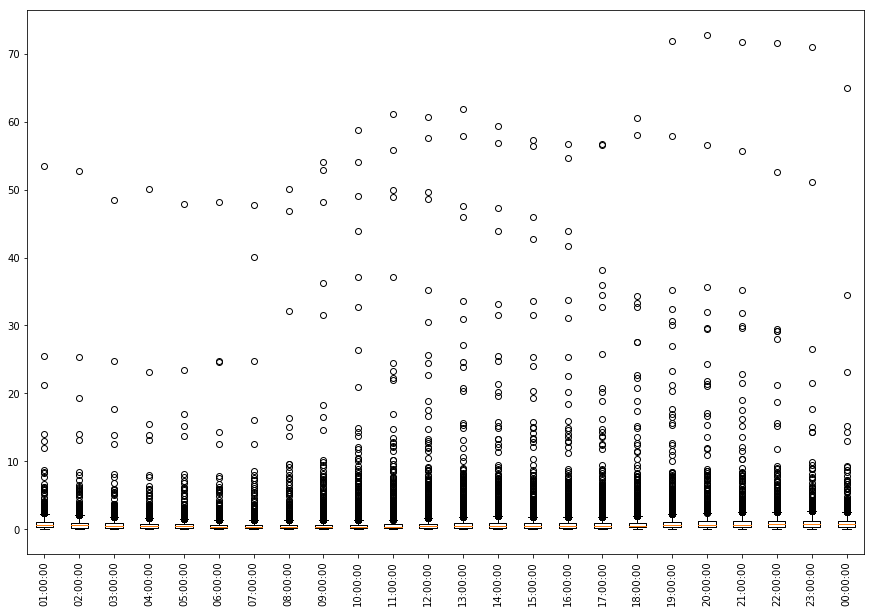

In [93]:
# 有畫 outlier
plt.figure(figsize=(15,10))
plt.boxplot(summer_avgdt_list, labels=all_times)
plt.xticks(rotation=90)

plt.show()

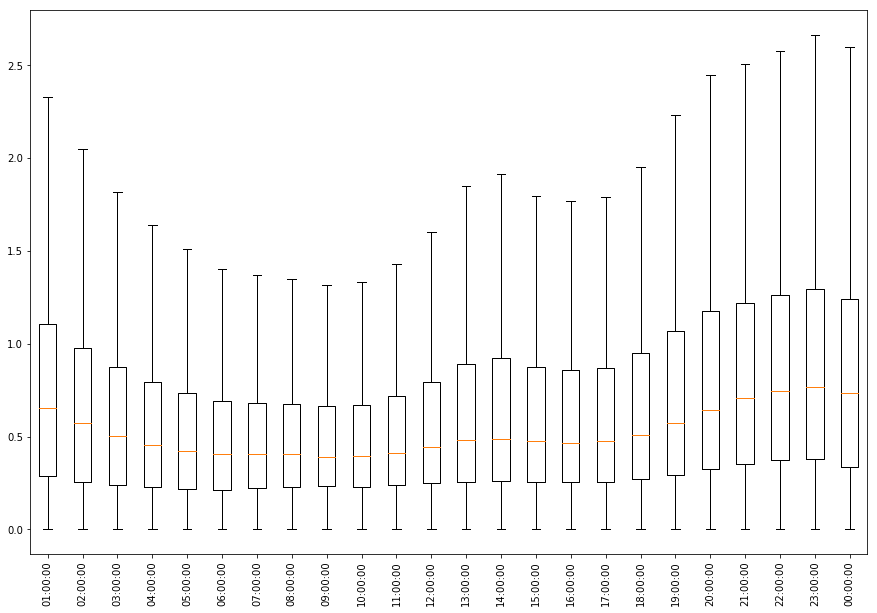

In [95]:
# 沒畫 outlier
plt.figure(figsize=(15,10))
plt.boxplot(summer_avgdt_list, 0, '', labels=all_times)
plt.xticks(rotation=90)

plt.show()

In [96]:
# 將所有時段做標準差，並儲存在 std_summer_avgdt
# std_summer_avgdt 為 dict, key: 每個時間點
#                         , value: 該時段的 std
std_summer_avgdt = {}
for k in summer_avgdt.keys():
    std_summer_avgdt[k] = np.std(summer_avgdt[k])

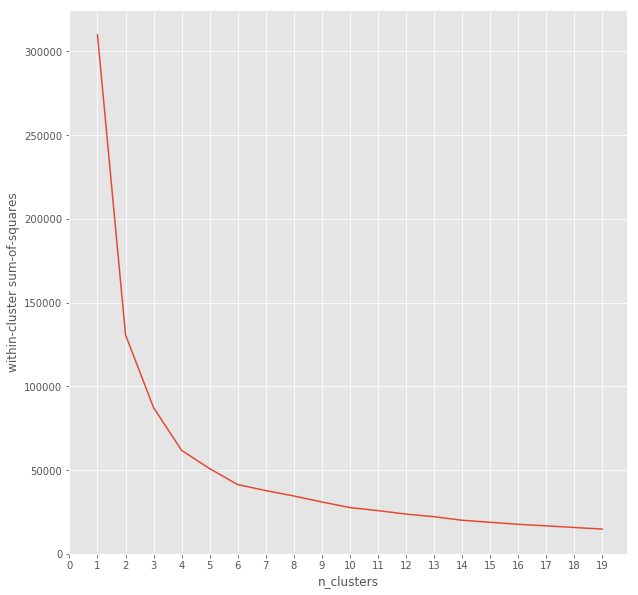

In [97]:
# 接著就是做分群了 ~

x = [summer_avgdt[k] for k in summer_avgdt.keys()]
X = [list(i) for i in zip(*x)]
ss=[]
for n in range(1,20):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
    ss.append(kmeans.inertia_)

plt.style.use('ggplot')
plt.figure(figsize=(10,10))
plt.plot(range(1,20),ss)
plt.xlabel("n_clusters")
plt.xticks( np.arange(20) )
plt.ylabel("within-cluster sum-of-squares")

In [100]:
# 挑轉折差別最大的點為分群數
n_c = 3
kmeans = KMeans(n_clusters=n_c, random_state=0).fit(X)
print(Counter(kmeans.labels_))

Counter({0: 3291, 1: 11, 2: 3})


In [101]:
groups = []
for i in range(n_c):
    groups.append({})
    for t in all_times:
        groups[i][t] = []

user_keys = [ k for k in summer_tdt.keys()]
for i in range(len(kmeans.labels_)):
    u = user_keys[i]
    g = kmeans.labels_[i]
    for t in all_times:
        groups[g][t].append(np.mean(summer_tdt[u][t]))


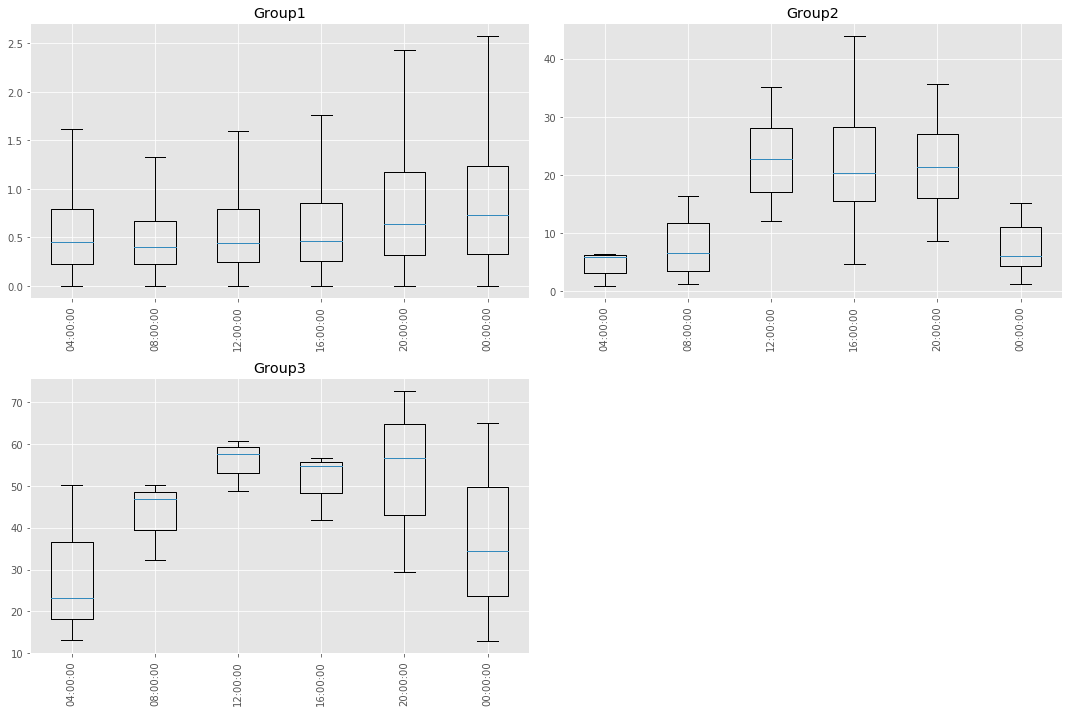

In [102]:
# 畫boxplot看個群的變異程度
plt.figure(figsize=(15,10))
for i in range(n_c):
    yy = [groups[i][t] for t in all_times]
    pyy = yy[3::4]
    pxx = all_times[3::4]
    plt.subplot(np.ceil(n_c/2),2,i+1)
    plt.title("Group"+str(i+1))
    plt.boxplot(pyy, 0, '', labels=pxx)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

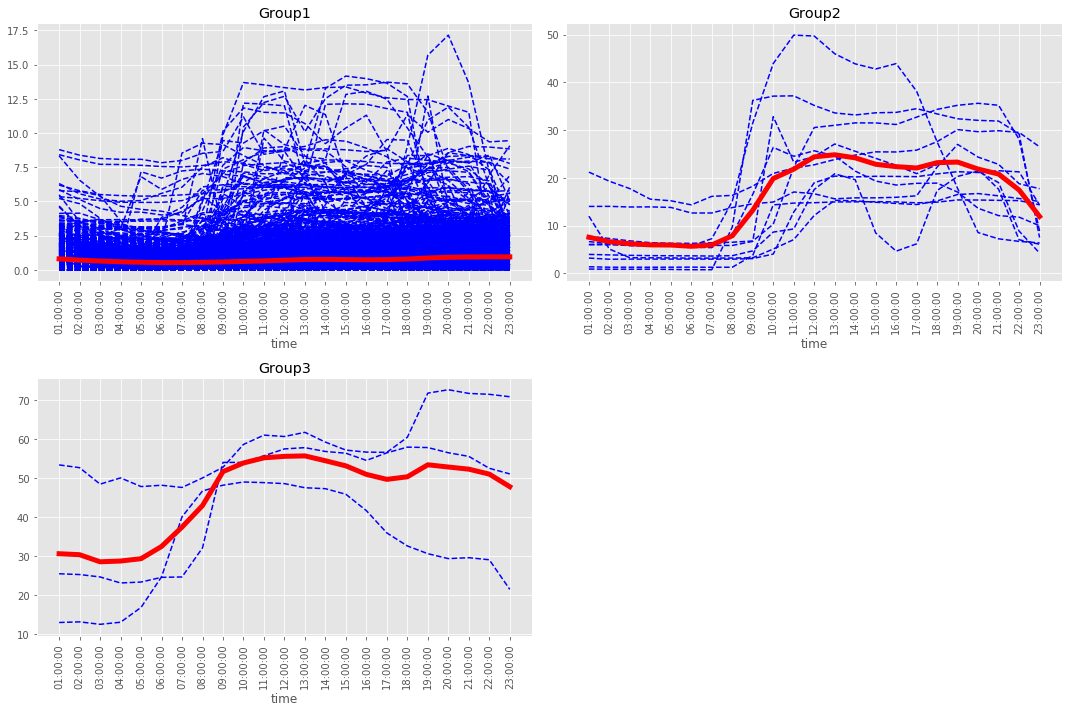

In [116]:
# 畫line plot看個群的相似度
plt.figure(figsize=(15,10))
for i in range(n_c):
    yy = [groups[i][t] for t in all_times[:-1]]
    y = [list(i) for i in zip(*yy)]
    plt.subplot(np.ceil(n_c/2),2,i+1)
    plt.title("Group"+str(i+1))
    #plt.ylim(0,2)
    for num in range(len(y)):
        plt.plot(all_times[:-1],y[num],'b--')
        #plt.scatter(all_times,y[num])
    plt.xticks(rotation=90)
    pyy = [np.mean(groups[i][t]) for t in all_times[:-1]]
    plt.plot(all_times[:-1], pyy,'r-',linewidth=5.0)
    plt.xticks(all_times[:-1])
    #plt.scatter(all_times[:-1], pyy,'r-',linewidth=5.0)
plt.tight_layout()
plt.savefig(region_name+'_clustering.png')
plt.show()

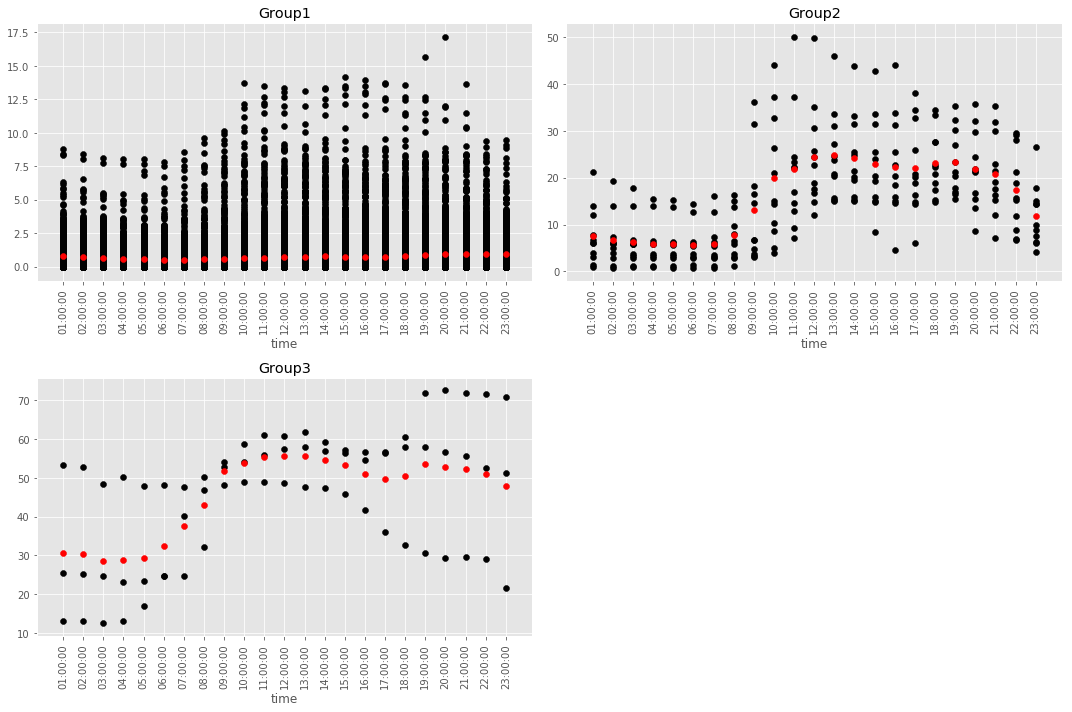

In [109]:
# 畫scatter plot看個群的相似度
plt.figure(figsize=(15,10))
for i in range(n_c):
    yy = [groups[i][t] for t in all_times[:-1]]
    y = [list(i) for i in zip(*yy)]
    plt.subplot(np.ceil(n_c/2),2,i+1)
    plt.title("Group"+str(i+1))
    #plt.ylim(0,2)
    for num in range(len(y)):
        #plt.plot(all_times[:-1],y[num],'b--')
        plt.scatter(all_times[:-1],y[num],color='black')
    plt.xticks(rotation=90)
    pyy = [np.mean(groups[i][t]) for t in all_times[:-1]]
    #plt.plot(all_times[:-1], pyy,'r-',linewidth=5.0)
    plt.scatter(all_times[:-1], pyy,color='red')
    plt.xticks(all_times[:-1])
plt.tight_layout()
plt.show()

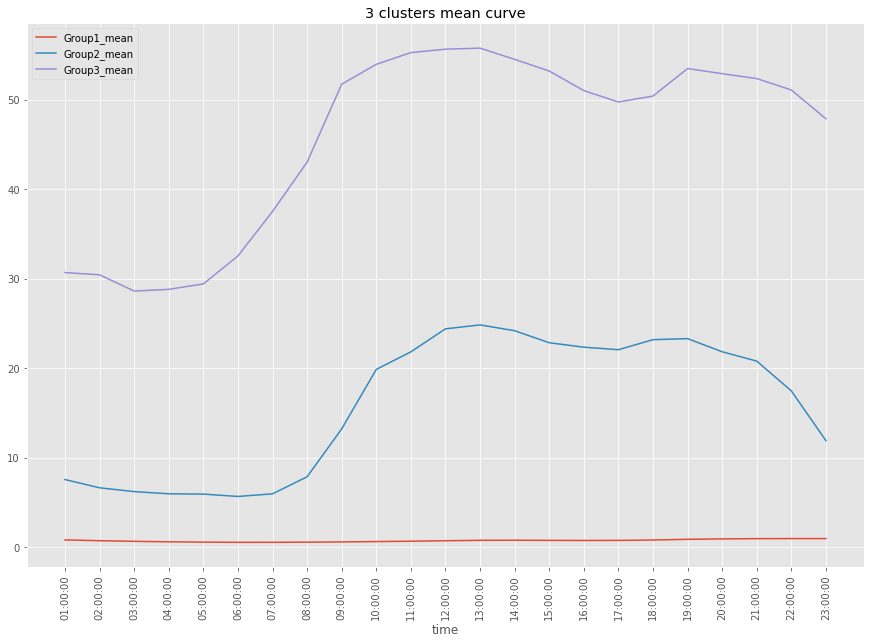

In [117]:
plt.figure(figsize=(15,10))
for i in range(n_c):
    yy = [np.mean(groups[i][t]) for t in all_times[:-1]]
    xx = all_times[:-1]
    plt.plot(xx, yy,label="Group"+str(i+1)+"_mean")
    plt.xticks(xx, xx, rotation=90)
plt.legend()
plt.title(str(n_c)+' clusters mean curve')
plt.savefig(region_name+'_clustering_mean_curve.png')
plt.show()